In [1]:
import tinygrad as tg
from tinygrad.tensor import Tensor
import numpy as np
from typing import Callable

# Do not pick MacOsx because it will crash the jupyter kernel 
#matplotlib.use('nbAgg')  # Replace 'TkAgg' with your preferred backend

# The goal is to express all polynomials with a neural network that only uses relu activation functions
# many thanks to Nikolaj-K @ https://www.youtube.com/watch?v=PApGm1TKFHQ for the topic
# rewrote it in a different way

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# Utils


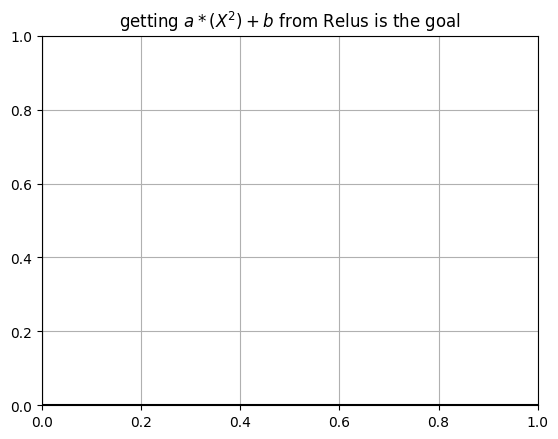

In [3]:
def plot(x: np.ndarray) -> Callable[[np.ndarray,str,str], None]:
    """
    Curries X into the plot function
    """
    def fn(y: np.ndarray, label: str, color: str) -> None:
        plt.plot(x, y, label=label, color=color)
    return lambda y,label,color : fn(y,label,color)


def plt_setup() -> None:
    plt.grid(True)
    plt.style.use('dark_background')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("getting $a*(X^2)+b$ from Relus is the goal")
    plt.style.use('dark_background')
    return None

plt_setup()

color_cycle = matplotlib.colormaps["Spectral"]


# STEP 1 : get X^2 from adding piecewise linear functions (triangle wave functions)

In [4]:
def triangle_wave(x: tg.Tensor) -> tg.Tensor:
    left = x-x.floor()
    right = x.ceil()-x
    return (left<right)*left +(left>=right)*right

def takagi(x: tg.Tensor, N:int) ->  tg.Tensor:
    #https://en.wikipedia.org/wiki/Blancmange_curve
    return tg.Tensor.stack([takagi_piece(x,i) for i in range(N)],dim=1).sum(axis=1)

def takagi_piece(x: tg.Tensor, i: int) -> tg.Tensor:
    w = 0.25 # w=1/4 gives the parabola !
    return (w**i) * triangle_wave((2**i)*x)

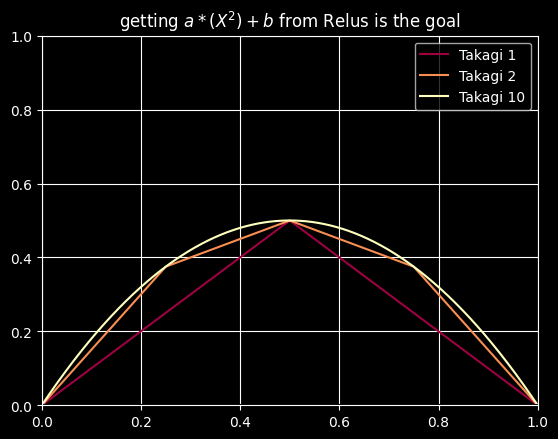

In [5]:
color_cycle = matplotlib.colormaps["Spectral"]
X=tg.Tensor.arange(0,1,0.001)
prt = plot(X.numpy())
prt(takagi(X,1).numpy(), "Takagi 1", color=color_cycle(0.0))
prt(takagi(X,2).numpy(), "Takagi 2", color=color_cycle(0.25))
prt(takagi(X,10).numpy(), "Takagi 10", color=color_cycle(0.5))
plt_setup()
plt.legend(loc='best')
plt.show()

# Step 2 : get the triangle wave functions from Relus

In [7]:
# MOVEMENT OPERATIONS ON FUNCTIONS OF TENSOR TO TENSOR

def shift(d:float, f: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Shifts a function by d
    towards the right if d>0
    """
    return lambda x: f(x-d)

def scale(a:float, f: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Scales a function by a
    """
    return lambda x: f(x/a)

def mul(a:float, f: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Multiplies a function by a
    """
    return lambda x: a*f(x)

def add(f: Callable[[tg.Tensor], tg.Tensor], g: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Adds two functions
    """
    return lambda x: f(x)+g(x)

def minus(f: Callable[[tg.Tensor], tg.Tensor]) -> Callable[[tg.Tensor], tg.Tensor]:
    """
    Flips a function along the x axis
    """
    return lambda x: -f(x)

In [8]:
def relu(x: Tensor) -> Tensor:
    return x.relu()

def anti_relu(lmd:float,d:float) : 
    # this destroys the previous relus with 
    # a new one that is shifted by d and scaled by lmd=lambda
    return mul(-lmd,shift(d,relu))

def triangle_1(x: Tensor) -> Tensor:
    return relu(x)-2*relu(x-0.5)

def triangle_2(x: Tensor) -> Tensor:
    return add(relu, flip(mul(2,shift(0.25,relu))))(x)

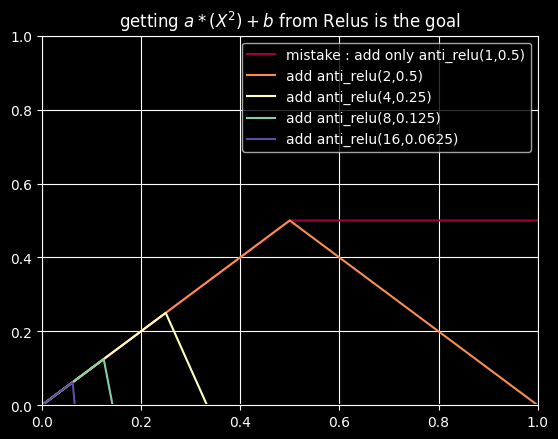

In [22]:
X = Tensor.arange(0,1,0.001)

# X.numpy() = relu(X).numpy()) # relu : the starting point

prt(add(relu,minus(shift(0.5,relu)))(X).numpy(), "mistake : add only anti_relu(1,0.5)", color=color_cycle(0.0))

# We cut in half the frist relu and create a triangle
triangle_1 = add(relu,anti_relu(2,0.5))(X).numpy()

prt(triangle_1, "add anti_relu(2,0.5)", color=color_cycle(0.25))

triangle_2 = add(relu,anti_relu(4,0.25))(X).numpy()

prt(triangle_2, "add anti_relu(4,0.25)", color=color_cycle(0.5))

triangle_3 = add(relu,anti_relu(8,0.125))(X).numpy()

prt(triangle_3, "add anti_relu(8,0.125)", color=color_cycle(0.75))

triangle_4 = add(relu,anti_relu(16,0.0625))(X).numpy()

prt(triangle_4, "add anti_relu(16,0.0625)", color=color_cycle(1.0))

plt_setup()
plt.legend(loc='best')
plt.show()

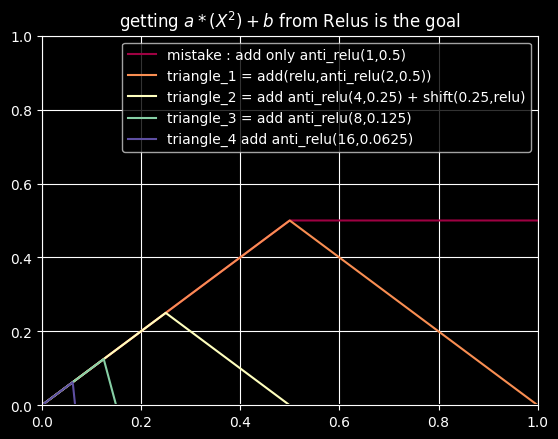

In [34]:
X = Tensor.arange(0,1,0.001)

# X.numpy() = relu(X).numpy()) # relu : the starting point

prt(add(relu,minus(shift(0.5,relu)))(X).numpy(), "mistake : add only anti_relu(1,0.5)", color=color_cycle(0.0))

# We cut in half the frist relu and create a triangle
triangle_1 = add(relu,anti_relu(2,0.5))

prt(triangle_1(X).numpy(), "triangle_1 = add(relu,anti_relu(2,0.5))", color=color_cycle(0.25))

triangle_2 = add(add(triangle_1,anti_relu(4,0.25)),mul(2,shift(0.25,relu)))

prt(triangle_2(X).numpy(), "triangle_2 = add anti_relu(4,0.25) + shift(0.25,relu)", color=color_cycle(0.5))

triangle_3 = add(add(triangle_2,anti_relu(8,0.125)),mul(2,shift(0.125,relu)))

prt(triangle_3(X).numpy(), "triangle_3 = add anti_relu(8,0.125)", color=color_cycle(0.75))

triangle_4 = add(add(triangle_3,anti_relu(16,0.0625)),mul(2,shift(0.0625,relu)))

prt(triangle_4(X).numpy(), "triangle_4 add anti_relu(16,0.0625)", color=color_cycle(1.0))

plt_setup()
plt.legend(loc='best')
plt.show()